In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
#Read Parquet file
df = pd.read_parquet('zippedData/merged_data.parquet')

In [3]:
#Add column to Df of properly formatted year
df['year'] = df['release_date'].dt.year
#Create new Df for only values with year 2010 or greater
genre = df.loc[df['year']>= 2010]
#Explode original Df by genre
genre_all = df.explode('genres')
#Explode year filtered Df by genre
genre = genre.explode('genres')

In [4]:
# filtered df by release date 

filtered_df_by_date = df.loc[df.release_date.dt.year >= 2012]
#filtered_df_by_date

In [5]:
# filtered df with genres column exploded

test_filtered_date = filtered_df_by_date.explode("genres")
#test_filtered_date

In [6]:
# df grouped by genre using filtered df
grouped_by_genre_filtered = test_filtered_date.groupby(["genres"]).median().sort_values("ROI", ascending = False).reset_index()
#grouped_by_genre_filtered

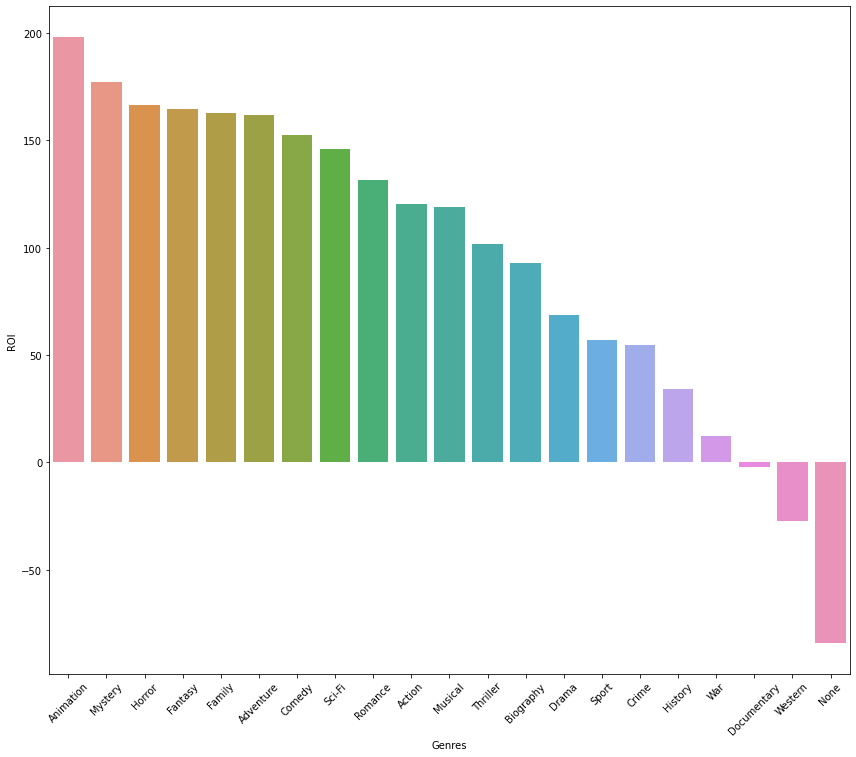

In [7]:
# bar plot of genre and ROI 

# fig = px.bar(grouped_by_genre_filtered, x = "genres", y = "ROI", color_discrete_sequence = ["Purple"])
# fig.show();

fig, ax = plt.subplots(figsize = (12, 10))
ax = sns.color_palette("husl", 9)
ax = sns.barplot(data = grouped_by_genre_filtered, x = "genres", y = "ROI")
ax.set(xlabel = "Genres", ylabel = "ROI")
plt.tight_layout()
plt.xticks(rotation = 45)
plt.savefig('./images/median_roi_by_genre.png')
plt.show();

In [8]:
#Create Df for Papa's 2010 and later data
recent = df.loc[df.release_date.dt.year >= 2010]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


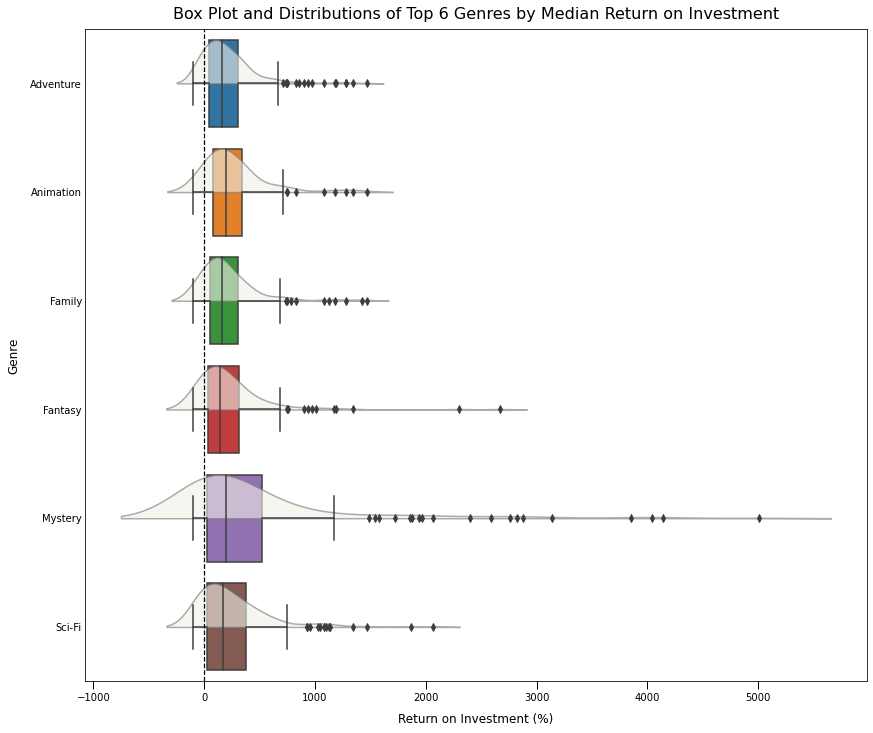

In [9]:
# Create dataframe expanded along genres using pd.explode
expanded_genres = recent.explode('genres')

# Create dataframe grouped by genres with median ROI, median product budget, and a count of titles in the genre
groupby_genres_median = expanded_genres.groupby('genres').agg({'ROI': 'median',
                                                               'prod_budget': 'median',
                                                               'title': 'count'})

# Recast title column as int for use in further filtering
groupby_genres_median.title = groupby_genres_median.title.astype(int)

# Filter by genres that have at least 75 titles in data set
groupby_genres_median = groupby_genres_median.loc[groupby_genres_median.title >= 75]

# Create a dataframe that represents the top 6 genres by median ROI
top_6_by_median = groupby_genres_median.nlargest(6, 'ROI')

# Create a dataframe grouped by genres then ROI, reset index to turn back into a dataframe rather than groupby object
# This allows grouping of data without having to use aggregate functions
groupby_genres_ROI = expanded_genres.groupby(['genres', 'ROI']).first()
groupby_genres_ROI = groupby_genres_ROI.reset_index()

# Create dataframes representing the top 9 genres and the 6 genres by median (less influenced by outliers)
top_6_genres_by_median_raw_ROI = groupby_genres_ROI.loc[groupby_genres_ROI.genres.isin(list(top_6_by_median.index))]

# Create an overlaid boxplot and violinplot for the top 6 genres by median to show distributions
# Declare fig, ax objects
fig, ax = plt.subplots(figsize=(14,12))

# Create seaborn boxplot
sns.boxplot(data = top_6_genres_by_median_raw_ROI,
            y = 'genres',
            x = 'ROI',
            orient = 'h',
            ax = ax)

# Create seaborn violinplot, forcibly creating a half violin by hueing only on true
sns.violinplot(data=top_6_genres_by_median_raw_ROI,
               orient='h',
               y='genres',
               x='ROI',
               inner='box',
               hue=True,
               hue_order = [True,False],
               split=True,
               color='#e7f294',
               ax=ax);

# Suppress legend created due to tricking violinplot to create half violin
ax.legend_ = None

# Set opacity of violinplot to 0.6
plt.setp(ax.collections, alpha=0.6)

# Create vertical line at ROI = 0 for clarity
ax.axvline(x=0, c='k', linestyle='--', linewidth=1.25);

# Set axis labels and title
ax.set_xlabel('Return on Investment (%)',
              fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 10)

ax.set_ylabel('Genre',
              fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 10)

ax.set_title('Box Plot and Distributions of Top 6 Genres by Median Return on Investment',
             fontfamily = 'Arial',
             fontsize = 16,
             pad = 10);

# Set tick labels
ax.tick_params(axis = 'both',
               which = 'major',
               labelsize = 10,
               length = 8,
               width = 1)

ax.tick_params(axis = 'y', length = 0, labelsize = 10)

# Set font for tick labels on both axes
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
    
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")


plt.savefig('./images/distribution_of_roi_by_genre.png')

In [10]:
#Create new Df of top 6 genres from all years Df
genre_all = genre_all[genre_all.genres.isin(['Sci-Fi', 'Mystery', 'Horror', 'Thriller','Romance', 'Animation'])]
#Select the medians each genre for each year
graph_all = genre_all.groupby(['year','genres']).median()
#Reset the index
graph_all.reset_index(inplace = True)

In [11]:
#Create Df of median by year (not broken up by genre)
ROI_by_year = genre_all.groupby('year').ROI.median()

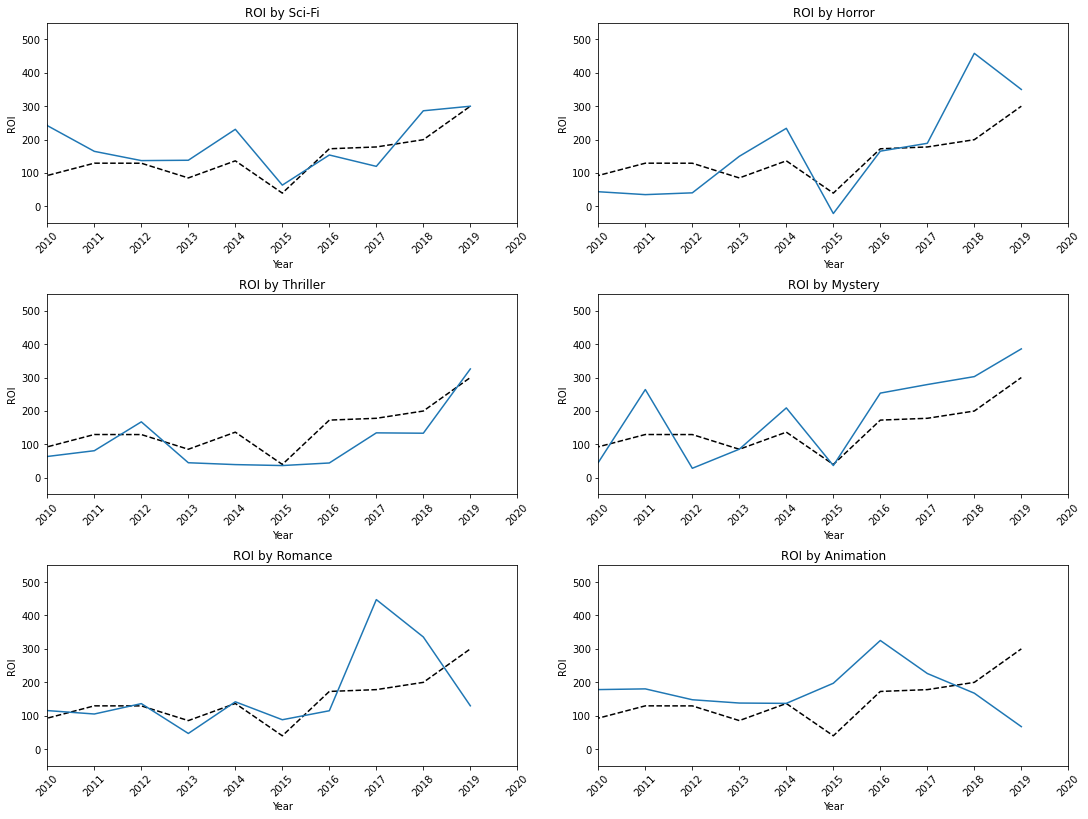

<Figure size 432x288 with 0 Axes>

In [12]:
#Plot all the top 6 genre medians between 2011 and 2019
fig, ax = plt.subplots(3,2,figsize = (16,12))
plt.tight_layout(pad = 5.0)
#Loop through unique genre names to plot to the 3 x 2 ax matrix
for index, gen in enumerate(list(graph_all.genres.unique())):
    axis = ax[index % 3][index // 3]
    sns.lineplot(x = ROI_by_year.index, y = ROI_by_year.values, color = 'black', linestyle = '--', ax = axis)
    sns.lineplot(data = graph_all,
                 x = 'year', y = graph_all.loc[graph_all.genres == gen].ROI,
                 ax = axis)
    axis.set_xlim([2010,2020])
    axis.set_ylim([-50,550])
    axis.set_xlabel('Year')
    axis.set_title(f'ROI by {gen}')
    axis.xaxis.set_major_locator(plt.MultipleLocator(1))
    #Loop through each axis tick and rotate
    for tick in axis.get_xticklabels():
        tick.set_rotation(45)

plt.show()

plt.savefig('./images/change_in_roi_by_genre.png')

In [13]:
#Explode genre Df since 2012 on Director
genre_dir = genre.explode('director')

In [14]:
#Create a Df for each of the top 6 genres and create the ROI_diff to standardize for comparison
animation = genre_dir.loc[genre_dir['genres']== 'Animation']
animation['ROI_diff'] = (animation['ROI'] - animation['ROI'].mean()) / animation['ROI'].mean() 

scifi = genre_dir.loc[genre_dir['genres']== 'Sci-Fi']
scifi['ROI_diff'] = (scifi['ROI'] - scifi['ROI'].mean()) / scifi['ROI'].mean() 

adventure = genre_dir.loc[genre_dir['genres']== 'Adventure']
adventure['ROI_diff'] = (adventure['ROI'] - adventure['ROI'].mean()) / adventure['ROI'].mean()

fantasy = genre_dir.loc[genre_dir['genres']== 'Fantasy']
fantasy['ROI_diff'] = (fantasy['ROI'] - fantasy['ROI'].mean()) / fantasy['ROI'].mean()

family = genre_dir.loc[genre_dir['genres']== 'Family']
family['ROI_diff'] = (family['ROI'] - family['ROI'].mean()) / family['ROI'].mean()

horror = genre_dir.loc[genre_dir['genres']== 'Horror']
horror['ROI_diff'] = (horror['ROI'] - horror['ROI'].mean()) / horror['ROI'].mean()

mystery = genre_dir.loc[genre_dir['genres']== 'Mystery']
mystery['ROI_diff'] = (mystery['ROI'] - mystery['ROI'].mean()) / mystery['ROI'].mean()

<ipython-input-14-892e0085da23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animation['ROI_diff'] = (animation['ROI'] - animation['ROI'].mean()) / animation['ROI'].mean()
<ipython-input-14-892e0085da23>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scifi['ROI_diff'] = (scifi['ROI'] - scifi['ROI'].mean()) / scifi['ROI'].mean()
<ipython-input-14-892e0085da23>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [15]:
#Create Df of the top 5 directors of each of the top genres
animation_dir = animation.groupby('director').mean().sort_values('ROI_diff', ascending = False).head(5)
animation_top = animation_dir.ROI_diff
animation_top = animation_top.to_frame()
animation_top['genre'] = ['Animation','Animation','Animation','Animation','Animation']
scifi_dir = scifi.groupby('director').mean().sort_values('ROI_diff', ascending = False).head(5)
scifi_top = scifi_dir.ROI_diff
scifi_top = scifi_top.to_frame()
scifi_top['genre'] = ['Sci-Fi','Sci-Fi','Sci-Fi','Sci-Fi','Sci-Fi']
adventure_dir = adventure.groupby('director').mean().sort_values('ROI_diff', ascending = False).head(5)
adventure_top = adventure_dir.ROI_diff
adventure_top = adventure_top.to_frame()
adventure_top['genre'] = ['Adventure','Adventure','Adventure','Adventure','Adventure']
fantasy_dir = fantasy.groupby('director').mean().sort_values('ROI_diff', ascending = False).head(5)
fantasy_top = fantasy_dir.ROI_diff
fantasy_top = fantasy_top.to_frame()
fantasy_top['genre'] = ['Fantasy','Fantasy','Fantasy','Fantasy','Fantasy']
family_dir = family.groupby('director').mean().sort_values('ROI_diff', ascending = False).head(5)
family_top = family_dir.ROI_diff
family_top = family_top.to_frame()
family_top['genre'] = ['Family','Family','Family','Family','Family']
horror_dir = horror.groupby('director').mean().sort_values('ROI_diff', ascending = False).head(5)
horror_top = horror_dir.ROI_diff
horror_top = horror_top.to_frame()
horror_top['genre'] = ['Horror','Horror','Horror','Horror','Horror']
mystery_dir = mystery.groupby('director').mean().sort_values('ROI_diff', ascending = False).head(5)
mystery_top = mystery_dir.ROI_diff
mystery_top = mystery_top.to_frame()
mystery_top['genre'] = ['Mystery','Mystery','Mystery','Mystery','Mystery']
# Select Dfs' to use for pd.concat
frames = [adventure_top, animation_top, scifi_top, fantasy_top, family_top, horror_top, mystery_top]
# Concatenate all the top directors by genre
top_all = pd.concat(frames)
# Get the top 15 overall directors of the top genres
top_15 = top_all.sort_values('ROI_diff', ascending = False).head(15)
top_15 = top_15.reset_index()

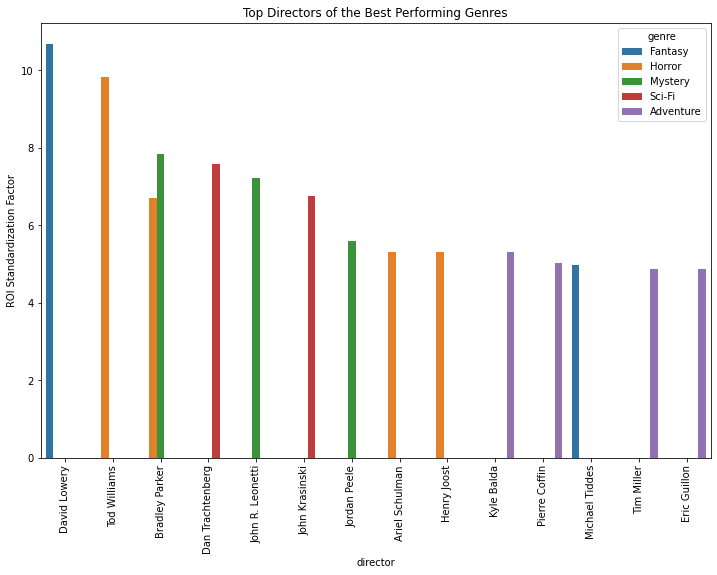

In [16]:
#Plot the top 15 Directors of the top genres
fig, ax = plt.subplots(figsize=(12,8))

sns.barplot(data = top_15, x = 'director', y = 'ROI_diff', hue = 'genre')
plt.xticks(rotation=90)
plt.title('Top Directors of the Best Performing Genres')
plt.ylabel('ROI Standardization Factor');

plt.savefig('./images/top_directors_by_genre.png')

In [17]:
# both genres and writers columns are exploded

test_filtered_date = test_filtered_date.explode("writer")
#test_filtered_date

In [18]:
# animation df with ROI_Diff

animation = test_filtered_date.loc[test_filtered_date["genres"] == "Animation"]
animation["ROI_Diff"] = (animation["ROI"] - animation["ROI"].mean()) / animation["ROI"].mean()

<ipython-input-18-d4144e7b3960>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animation["ROI_Diff"] = (animation["ROI"] - animation["ROI"].mean()) / animation["ROI"].mean()


In [19]:
animation_df = animation.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head(5)
animation_top = animation_df["ROI_Diff"]
animation_top = animation_top.to_frame()
animation_top["genre"] = ["Animation", "Animation", "Animation", "Animation", "Animation"]

In [20]:
# mystery df and ROI Diff

mystery = test_filtered_date.loc[test_filtered_date["genres"] == "Mystery"]
mystery["ROI_Diff"] = (mystery["ROI"] - mystery["ROI"].mean()) / mystery["ROI"].mean()

<ipython-input-20-d00cf4b38095>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mystery["ROI_Diff"] = (mystery["ROI"] - mystery["ROI"].mean()) / mystery["ROI"].mean()


In [21]:
mystery_df = mystery.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head(5)
mystery_top = mystery_df["ROI_Diff"]
mystery_top = mystery_top.to_frame()
mystery_top["genre"] = ["Mystery", "Mystery", "Mystery", "Mystery", "Mystery"]

In [22]:
# horror df and ROI Diff

horror = test_filtered_date.loc[test_filtered_date["genres"] == "Horror"]
horror["ROI_Diff"] = (horror["ROI"] - horror["ROI"].mean()) / horror["ROI"].mean()

<ipython-input-22-3776e259a7c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horror["ROI_Diff"] = (horror["ROI"] - horror["ROI"].mean()) / horror["ROI"].mean()


In [23]:
horror_df = horror.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head()
horror_top = horror_df["ROI_Diff"]
horror_top = horror_top.to_frame()
horror_top["genre"] = ["Horror", "Horror", "Horror", "Horror", "Horror"]

In [24]:
# fantasy df and ROI Diff

fantasy = test_filtered_date.loc[test_filtered_date["genres"] == "Fantasy"]
fantasy["ROI_Diff"] = (fantasy["ROI"] - fantasy["ROI"].mean()) / fantasy["ROI"].mean()

<ipython-input-24-35371e24dd37>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fantasy["ROI_Diff"] = (fantasy["ROI"] - fantasy["ROI"].mean()) / fantasy["ROI"].mean()


In [25]:
fantasy_df = fantasy.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head()
fantasy_top = fantasy_df["ROI_Diff"]
fantasy_top = fantasy_top.to_frame()
fantasy_top["genre"] = ["Fantasy", "Fantasy", "Fantasy", "Fantasy", "Fantasy"]

In [26]:
# family df and ROI Diff

family = test_filtered_date.loc[test_filtered_date["genres"] == "Family"]
family["ROI_Diff"] = (family["ROI"] - family["ROI"].mean()) / family["ROI"].mean()

<ipython-input-26-e4c8ddf98b19>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family["ROI_Diff"] = (family["ROI"] - family["ROI"].mean()) / family["ROI"].mean()


In [27]:
family_df = family.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head()
family_top = family_df["ROI_Diff"]
family_top = family_top.to_frame()
family_top["genre"] = ["Family", "Family", "Family", "Family", "Family"]

In [28]:
# adventure df and ROI Diff

adventure = test_filtered_date.loc[test_filtered_date["genres"] == "Adventure"]
adventure["ROI_Diff"] = (adventure["ROI"] - adventure["ROI"].mean()) / adventure["ROI"].mean()

<ipython-input-28-d2b2d9b6fdf0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adventure["ROI_Diff"] = (adventure["ROI"] - adventure["ROI"].mean()) / adventure["ROI"].mean()


In [29]:
adventure_df = adventure.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head()
adventure_top = adventure_df["ROI_Diff"]
adventure_top = adventure_top.to_frame()
adventure_top["genre"] = ["Adventure", "Adventure", "Adventure", "Adventure", "Adventure"]

In [30]:
# sci_fi df and ROI Diff

sci_fi = test_filtered_date.loc[test_filtered_date["genres"] == "Sci-Fi"]
sci_fi["ROI_Diff"] = (sci_fi["ROI"] - sci_fi["ROI"].mean()) / sci_fi["ROI"].mean()

<ipython-input-30-87b326f89b29>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sci_fi["ROI_Diff"] = (sci_fi["ROI"] - sci_fi["ROI"].mean()) / sci_fi["ROI"].mean()


In [31]:
sci_fi_df = sci_fi.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head()
sci_fi_top = sci_fi_df["ROI_Diff"]
sci_fi_top = sci_fi_top.to_frame()
sci_fi_top["genre"] = ["Sci-Fi", "Sci-Fi", "Sci-Fi", "Sci-Fi", "Sci-Fi"]

In [32]:
# sorted and concatenated df's of top genres 

concat_genre_df = pd.concat([animation_top, mystery_top, horror_top, fantasy_top, family_top, adventure_top, sci_fi_top], axis = 0)
sorted_genre_df= concat_genre_df.sort_values("ROI_Diff", ascending = False).reset_index().head(15)

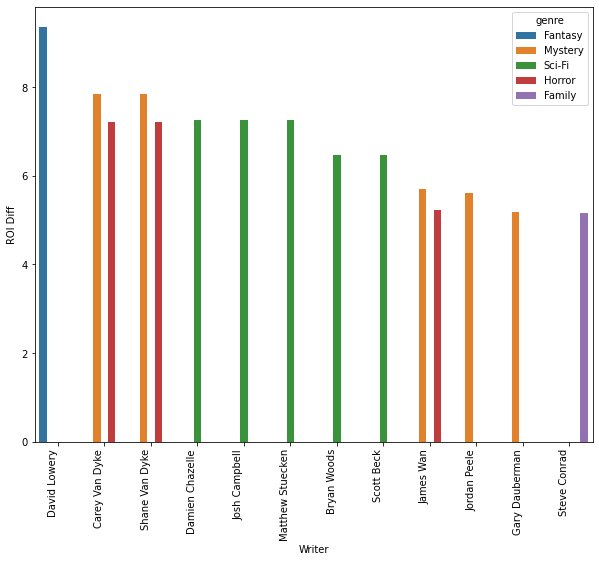

<Figure size 432x288 with 0 Axes>

In [35]:
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.color_palette("flare", 9)
ax = sns.barplot(data = sorted_genre_df, x = "writer", y = "ROI_Diff", hue = "genre")
ax.set_xticklabels(ax.get_xticklabels(), rotation= 90, ha="right")
ax.set(xlabel = "Writer", ylabel = "ROI Diff")
plt.tight_layout
plt.show();
plt.savefig('./images/top_writers_by_genre.png')

<ipython-input-36-105561a44e72>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animation["ROI_Diff"] = (animation["ROI"] - animation["ROI"].mean()) / animation["ROI"].mean()
<ipython-input-36-105561a44e72>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mystery["ROI_Diff"] = (mystery["ROI"] - mystery["ROI"].mean()) / mystery["ROI"].mean()
<ipython-input-36-105561a44e72>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

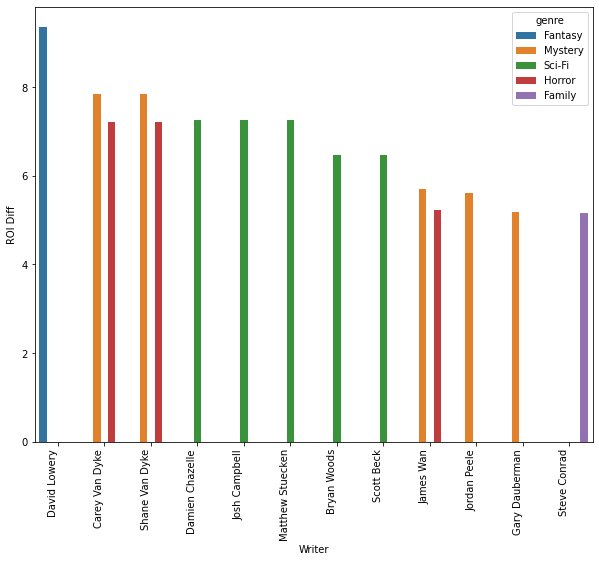

In [36]:
# both genres and writers columns are exploded

test_filtered_date = test_filtered_date.explode("writer")
#test_filtered_date

# animation df with ROI_Diff

animation = test_filtered_date.loc[test_filtered_date["genres"] == "Animation"]
animation["ROI_Diff"] = (animation["ROI"] - animation["ROI"].mean()) / animation["ROI"].mean()

animation_df = animation.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head(5)
animation_top = animation_df["ROI_Diff"]
animation_top = animation_top.to_frame()
animation_top["genre"] = ["Animation", "Animation", "Animation", "Animation", "Animation"]

# mystery df and ROI Diff

mystery = test_filtered_date.loc[test_filtered_date["genres"] == "Mystery"]
mystery["ROI_Diff"] = (mystery["ROI"] - mystery["ROI"].mean()) / mystery["ROI"].mean()

mystery_df = mystery.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head(5)
mystery_top = mystery_df["ROI_Diff"]
mystery_top = mystery_top.to_frame()
mystery_top["genre"] = ["Mystery", "Mystery", "Mystery", "Mystery", "Mystery"]

# horror df and ROI Diff

horror = test_filtered_date.loc[test_filtered_date["genres"] == "Horror"]
horror["ROI_Diff"] = (horror["ROI"] - horror["ROI"].mean()) / horror["ROI"].mean()

horror_df = horror.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head()
horror_top = horror_df["ROI_Diff"]
horror_top = horror_top.to_frame()
horror_top["genre"] = ["Horror", "Horror", "Horror", "Horror", "Horror"]

# fantasy df and ROI Diff

fantasy = test_filtered_date.loc[test_filtered_date["genres"] == "Fantasy"]
fantasy["ROI_Diff"] = (fantasy["ROI"] - fantasy["ROI"].mean()) / fantasy["ROI"].mean()

fantasy_df = fantasy.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head()
fantasy_top = fantasy_df["ROI_Diff"]
fantasy_top = fantasy_top.to_frame()
fantasy_top["genre"] = ["Fantasy", "Fantasy", "Fantasy", "Fantasy", "Fantasy"]

# family df and ROI Diff

family = test_filtered_date.loc[test_filtered_date["genres"] == "Family"]
family["ROI_Diff"] = (family["ROI"] - family["ROI"].mean()) / family["ROI"].mean()

family_df = family.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head()
family_top = family_df["ROI_Diff"]
family_top = family_top.to_frame()
family_top["genre"] = ["Family", "Family", "Family", "Family", "Family"]

# adventure df and ROI Diff

adventure = test_filtered_date.loc[test_filtered_date["genres"] == "Adventure"]
adventure["ROI_Diff"] = (adventure["ROI"] - adventure["ROI"].mean()) / adventure["ROI"].mean()

adventure_df = adventure.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head()
adventure_top = adventure_df["ROI_Diff"]
adventure_top = adventure_top.to_frame()
adventure_top["genre"] = ["Adventure", "Adventure", "Adventure", "Adventure", "Adventure"]

# sci_fi df and ROI Diff

sci_fi = test_filtered_date.loc[test_filtered_date["genres"] == "Sci-Fi"]
sci_fi["ROI_Diff"] = (sci_fi["ROI"] - sci_fi["ROI"].mean()) / sci_fi["ROI"].mean()

sci_fi_df = sci_fi.groupby(["writer"]).mean().sort_values("ROI_Diff", ascending = False).head()
sci_fi_top = sci_fi_df["ROI_Diff"]
sci_fi_top = sci_fi_top.to_frame()
sci_fi_top["genre"] = ["Sci-Fi", "Sci-Fi", "Sci-Fi", "Sci-Fi", "Sci-Fi"]

# sorted and concatenated df's of top genres 

concat_genre_df = pd.concat([animation_top, mystery_top, horror_top, fantasy_top, family_top, adventure_top, sci_fi_top], axis = 0)
sorted_genre_df= concat_genre_df.sort_values("ROI_Diff", ascending = False).reset_index().head(15)

fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.color_palette("flare", 9)
ax = sns.barplot(data = sorted_genre_df, x = "writer", y = "ROI_Diff", hue = "genre")
ax.set_xticklabels(ax.get_xticklabels(), rotation= 90, ha="right")
ax.set(xlabel = "Writer", ylabel = "ROI Diff")
plt.tight_layout
plt.show();

## Runtime vs. ROI

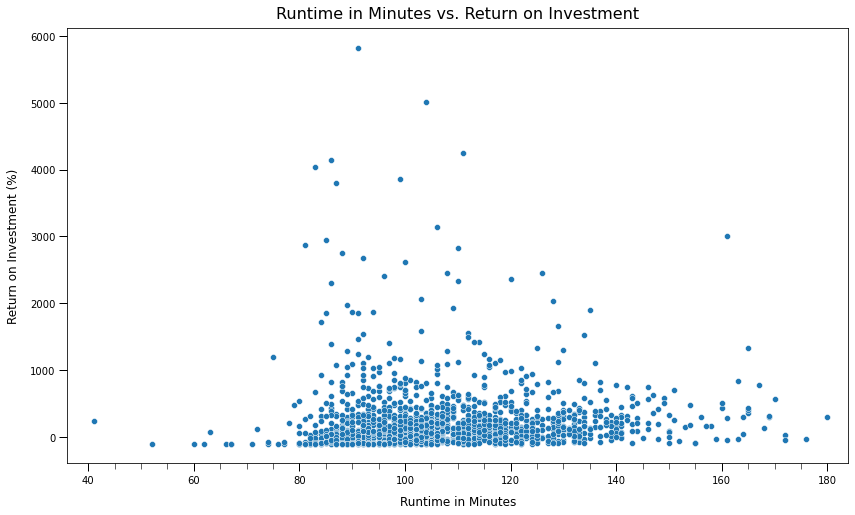

In [37]:
# Create seaborn scatterplot of runtime_min vs. ROI
# Not much semblance of correlation - if you are between ~90 and ~135 minutes (which is almost every movie), you make money
# Runtimes are all pretty close, the spread is not significant enough to try to separate into categorical "bins"

# Declare fig, ax objects as subplots
fig, ax = plt.subplots(figsize = (14, 8))

# Create seaborn scatterplot
sns.scatterplot(data = recent,
                x = 'runtime_min',
                y = 'ROI',
               ax = ax);

# Set axis labels and title
ax.set_xlabel('Runtime in Minutes',
              fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 10)

ax.set_ylabel('Return on Investment (%)',
              fontfamily = 'Arial',
              fontsize = 12,
              labelpad = 10)

ax.set_title('Runtime in Minutes vs. Return on Investment',
             fontfamily = 'Arial',
             fontsize = 16,
             pad = 10)

# Set boundaries for x-axis
ax.set_xlim([36, 184])

# Turn on minor ticks, set tick parameters
ax.minorticks_on()
ax.yaxis.set_tick_params(which = 'minor', left = False)

ax.tick_params(axis = 'both',
               which = 'major',
               labelsize = 10,
               length = 8,
               width = 1)

ax.tick_params(axis = 'both',
               which = 'minor',
               length = 6)

# Set font for tick labels on both axes
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
    
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
    
plt.savefig('./images/runtime_and_roi.png')